In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import mean
from numpy import array
from prettytable import PrettyTable
from tqdm import tqdm_notebook

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


This article covers the main method used: https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

In [2]:
# Read in the CSV
incidents = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv", low_memory=False)
incidents = incidents.dropna()
incidents.head()

publicAddress    caseNumber precinct offense           description  \
0   0056Xx Lyndale Av S  MP2010000051        5    CSCR    Crim Sex Cond-Rape   
1        0001Xx 62 St W  MP2010000099        5  ROBPAG       Robbery Per Agg   
2         0039Xx 5 Av S  MP2010000373        3   BURGD  Burglary Of Dwelling   
3  0013Xx Nicollet Av S  MP2010000305        1   ASLT2  Asslt W/Dngrs Weapon   
4    0034Xx Oliver Av N  MP2010000229        4   BURGD  Burglary Of Dwelling   

   ucrCode        lat        lon neighborhood incidentDate incidentTime  
0      3.0  44.900291 -93.288239       Windom   2010/01/01        00:30  
1      4.0  44.890636 -93.280041       Windom   2010/01/01        01:05  
2      6.0  44.931448 -93.268841       Bryant   2010/01/01        04:18  
3      5.0  44.970506 -93.277714  Loring Park   2010/01/01        03:00  
4      6.0  45.017746 -93.306988      Folwell   2010/01/01        02:23

In [8]:
# Reset the index to date, and split the date into fields for analysis
incidents.index = pd.DatetimeIndex(incidents.incidentDate)

incidents['month'] = incidents.index.month
incidents['year'] = incidents.index.year
incidents['dayOfWeek'] = incidents.index.dayofweek
incidents['dayOfMonth'] = incidents.index.day
incidents['dayOfYear'] = incidents.index.dayofyear
incidents['weekOfMonth'] = incidents.dayOfMonth.apply(lambda d: (d-1) // 7 +1)

dayOfYear = list(incidents.index.dayofyear)
weekOfYear = [math.ceil(i/7) for i in dayOfYear]
incidents['weekOfYear'] = weekOfYear

incidents = incidents.sort_index()

incidents.loc[(incidents['neighborhood'] == "Steven'S Square - Loring Heights"), 'neighborhood'] = 'Stevens Square - Loring Heights'

incidents.head()

publicAddress    caseNumber precinct offense  \
incidentDate                                                       
2010-01-01    0056Xx Lyndale Av S  MP2010000051        5    CSCR   
2010-01-01       0021Xx Lake St E  MP2010001305        3   BURGB   
2010-01-01       0021Xx Lake St E  MP2010001306        3   BURGB   
2010-01-01       0021Xx Lake St E  MP2010001311        3   BURGB   
2010-01-01         0018Xx 6 St Ne  MP2010002789        2    CSCR   

                       description  ucrCode        lat        lon  \
incidentDate                                                        
2010-01-01      Crim Sex Cond-Rape      3.0  44.900291 -93.288239   
2010-01-01    Burglary Of Business      6.0  44.948372 -93.241320   
2010-01-01    Burglary Of Business      6.0  44.948372 -93.241320   
2010-01-01    Burglary Of Business      6.0  44.948372 -93.241320   
2010-01-01      Crim Sex Cond-Rape      3.0  45.006353 -93.258512   

             neighborhood incidentDate incidentTime  month  year  dayOfWeek  \
incidentDate                                                                  
2010-01-01         Windom   2010/01/01        00:30      1  2010          4   
2010-01-01       Corcoran   2010/01/01        22:44      1  2010          4   
2010-01-01       Corcoran   2010/01/01        22:44      1  2010          4   
2010-01-01       Corcoran   2010/01/01        22:44      1  2010          4   
2010-01-01        Holland   2010/01/01        03:30      1  2010          4   

              dayOfMonth  dayOfYear  weekOfMonth  weekOfYear  
incidentDate                                                  
2010-01-01             1          1            1           1  
2010-01-01             1          1            1           1  
2010-01-01             1          1            1           1  
2010-01-01             1          1            1           1  
2010-01-01             1          1            1           1

In [9]:
# Training on 2010-2017 data, then using 2019 for testing. Need to investigate 2018 data - seems like we lost a large number of records potentially during the data cleaning phase when we dropped NAs
incidents_train = incidents.loc['2010-01-01':'2017-12-31']
incidents_test = incidents.loc['2019-01-01':'2019-12-31']

# Setup Train and Test Data Sets for Monthly Predictions

In [10]:
neighborhood_list = list(incidents['neighborhood'].unique())
print(neighborhood_list)

['Windom', 'Corcoran', 'Holland', 'Downtown West', 'Standish', 'North Loop', 'Hawthorne', 'Loring Park', 'East Harriet', 'Lind - Bohanon', 'Como', 'Victory', 'Lyndale', 'Shingle Creek', 'Mckinley', 'St. Anthony East', 'Willard - Hay', 'Ecco', 'Whittier', 'Nicollet Island - East Bank', 'Columbia Park', 'Wenonah', 'Marcy Holmes', 'Longfellow', 'Central', 'Phillips West', 'Jordan', 'Folwell', 'Bryant', 'Cedar - Isles - Dean', 'Webber - Camden', 'Mid - City Industrial', 'University Of Minnesota', 'Camden Industrial', 'East Phillips', 'Carag', 'East Isles', 'Ventura Village', 'Hiawatha', 'West Calhoun', 'Powderhorn Park', 'Near - North', 'Midtown Phillips', 'Downtown East', 'Elliot Park', 'Harrison', 'Hale', 'Keewaydin', 'Waite Park', 'Logan Park', 'Lowry Hill East', 'Bottineau', 'Lowry Hill', 'Seward', 'Diamond Lake', 'Cooper', 'Tangletown', 'Northrop', 'Prospect Park - East River Road', 'Audubon Park', 'Cedar Riverside', 'Field', 'Minnehaha', 'Sumner - Glenwood', 'Howe', 'Marshall Terrace

In [11]:
# Training data by neighborhood by month
train_n = []
for neighborhood in neighborhood_list:
    df = incidents_train[incidents_train['neighborhood'] == neighborhood]
    df_gr = df.groupby(['year', 'month']).count()
    train_n.append(list(df_gr['incidentDate'].values))

In [12]:
# Testing data by neighborhood by month
test_n = []
for neighborhood in neighborhood_list:
    df = incidents_test[incidents_test['neighborhood'] == neighborhood]
    df_gr = df.groupby(['month']).count()
    test_n.append(list(df_gr['incidentDate'].values))

## Simple Moving Average

Neighborhood #: 1
Name: Windom
Actuals: [16, 14, 14, 10, 12, 14, 9, 10, 22, 18, 21, 20]
Predictions: [12.4, 12.8, 13.6, 14.6, 13.8, 13.2, 12.8, 11.8, 11.0, 13.4, 14.6, 16.0]


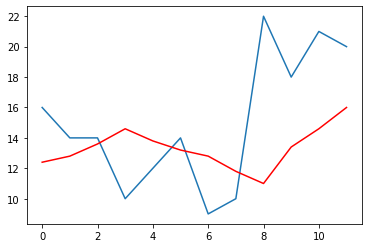

Neighborhood #: 2
Name: Corcoran
Actuals: [11, 5, 6, 19, 12, 18, 14, 27, 24, 12, 22, 19]
Predictions: [13.6, 12.2, 10.4, 8.0, 9.4, 10.6, 12.0, 13.8, 18.0, 19.0, 19.0, 19.8]


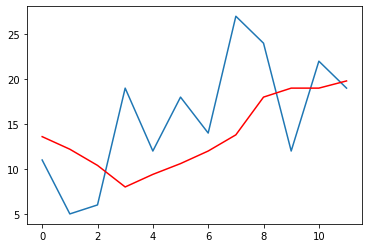

Neighborhood #: 3
Name: Holland
Actuals: [10, 11, 10, 18, 16, 10, 13, 25, 15, 19, 20, 19]
Predictions: [21.4, 19.6, 18.2, 16.2, 15.0, 13.0, 13.0, 13.4, 16.4, 15.8, 16.4, 18.4]


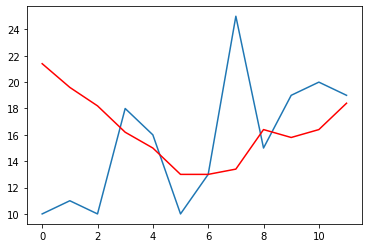

Neighborhood #: 4
Name: Downtown West
Actuals: [155, 121, 170, 170, 203, 231, 203, 221, 149, 180, 150, 165]
Predictions: [181.0, 167.0, 154.6, 153.4, 155.8, 163.8, 179.0, 195.4, 205.6, 201.4, 196.8, 180.6]


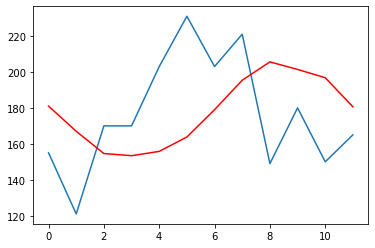

Neighborhood #: 5
Name: Standish
Actuals: [9, 9, 22, 28, 21, 21, 18, 14, 35, 23, 25, 20]
Predictions: [20.8, 16.2, 12.6, 13.4, 15.6, 17.8, 20.2, 22.0, 20.4, 21.8, 22.2, 23.0]


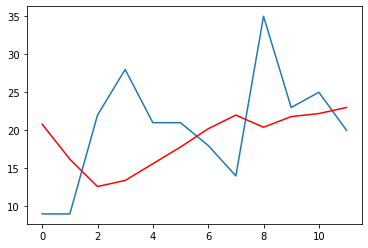

Neighborhood #: 6
Name: North Loop
Actuals: [21, 16, 13, 28, 37, 41, 50, 43, 47, 36, 37, 35]
Predictions: [40.8, 33.0, 26.2, 21.2, 20.4, 23.0, 27.0, 33.8, 39.8, 43.6, 43.4, 42.6]


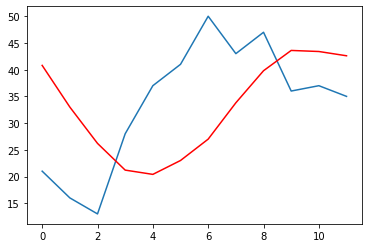

Neighborhood #: 7
Name: Hawthorne
Actuals: [43, 22, 32, 28, 41, 31, 54, 30, 52, 37, 45, 47]
Predictions: [42.0, 42.2, 37.2, 33.4, 32.4, 33.2, 30.8, 37.2, 36.8, 41.6, 40.8, 43.6]


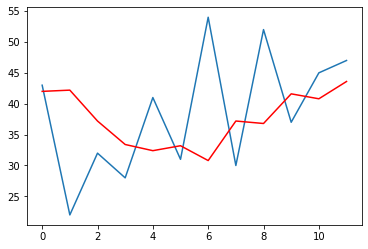

Neighborhood #: 8
Name: Loring Park
Actuals: [25, 24, 32, 26, 36, 42, 48, 52, 41, 43, 39, 40]
Predictions: [40.8, 38.0, 30.6, 27.0, 27.2, 28.6, 32.0, 36.8, 40.8, 43.8, 45.2, 44.6]


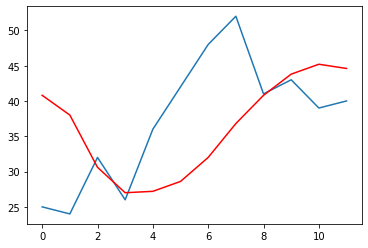

Neighborhood #: 9
Name: East Harriet
Actuals: [8, 4, 8, 5, 14, 15, 6, 9, 8, 8, 13, 7]
Predictions: [10.4, 9.8, 8.6, 7.6, 6.6, 7.8, 9.2, 9.6, 9.8, 10.4, 9.2, 8.8]


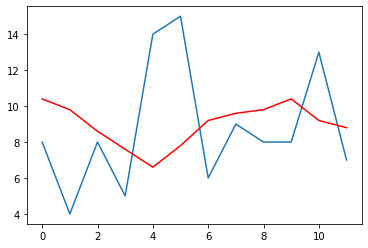

Neighborhood #: 10
Name: Lind - Bohanon
Actuals: [21, 14, 12, 18, 23, 23, 27, 16, 27, 28, 21, 16]
Predictions: [20.2, 21.0, 20.0, 19.2, 19.0, 17.6, 18.0, 20.6, 21.4, 23.2, 24.2, 23.8]


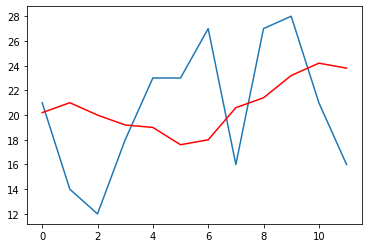

Neighborhood #: 11
Name: Como
Actuals: [26, 11, 15, 19, 16, 20, 15, 28, 20, 17, 23, 15]
Predictions: [23.4, 23.8, 21.8, 20.2, 19.4, 17.4, 16.2, 17.0, 19.6, 19.8, 20.0, 20.6]


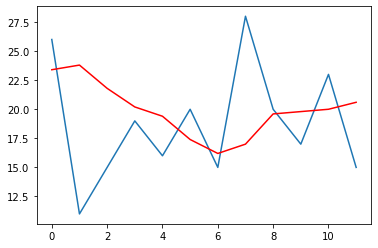

Neighborhood #: 12
Name: Victory
Actuals: [9, 7, 7, 9, 4, 19, 9, 12, 9, 13, 11, 10]
Predictions: [15.2, 15.0, 13.4, 12.0, 9.6, 7.2, 9.2, 9.6, 10.6, 10.6, 12.4, 10.8]


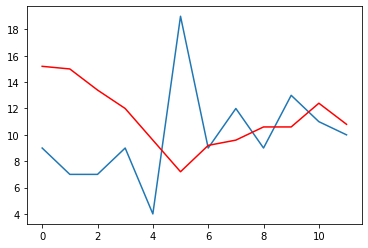

Neighborhood #: 13
Name: Lyndale
Actuals: [16, 16, 17, 16, 42, 42, 33, 38, 25, 25, 29, 27]
Predictions: [36.4, 31.2, 25.2, 23.2, 20.0, 21.4, 26.6, 30.0, 34.2, 36.0, 32.6, 30.0]


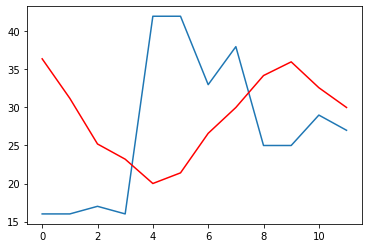

Neighborhood #: 14
Name: Shingle Creek
Actuals: [5, 4, 4, 8, 2, 8, 5, 9, 3, 9, 8, 9]
Predictions: [9.6, 8.2, 6.6, 7.0, 6.6, 4.6, 5.2, 5.4, 6.4, 5.4, 6.8, 6.8]


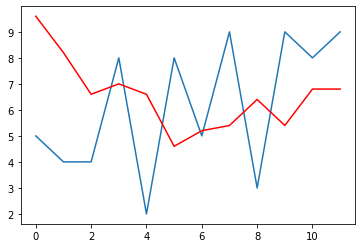

Neighborhood #: 15
Name: Mckinley
Actuals: [11, 15, 9, 19, 16, 16, 11, 10, 16, 14, 18, 13]
Predictions: [19.0, 17.8, 15.8, 13.2, 14.2, 14.0, 15.0, 14.2, 14.4, 13.8, 13.4, 13.8]


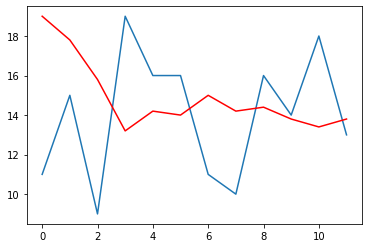

Neighborhood #: 16
Name: St. Anthony East
Actuals: [4, 2, 1, 4, 3, 4, 8, 6, 4, 3, 6, 5]
Predictions: [6.6, 6.0, 4.6, 3.8, 3.4, 2.8, 2.8, 4.0, 5.0, 5.0, 5.0, 5.4]


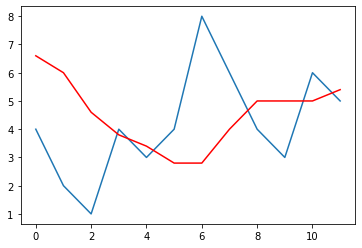

Neighborhood #: 17
Name: Willard - Hay
Actuals: [26, 20, 19, 31, 29, 35, 34, 27, 27, 21, 20, 29]
Predictions: [35.4, 34.2, 30.6, 26.4, 26.0, 25.0, 26.8, 29.6, 31.2, 30.4, 28.8, 25.8]


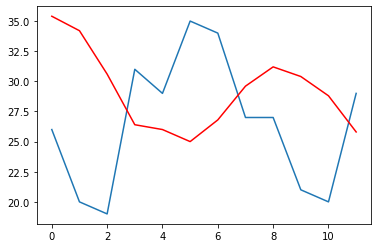

Neighborhood #: 18
Name: Ecco
Actuals: [20, 12, 11, 14, 17, 12, 14, 9, 16, 7, 15, 2]
Predictions: [20.8, 20.6, 19.6, 17.0, 14.2, 14.8, 13.2, 13.6, 13.2, 13.6, 11.6, 12.2]


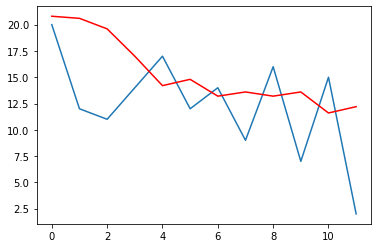

Neighborhood #: 19
Name: Whittier
Actuals: [67, 50, 77, 78, 89, 109, 97, 100, 127, 71, 89, 74]
Predictions: [74.2, 73.0, 67.2, 65.4, 66.4, 72.2, 80.6, 90.0, 94.6, 104.4, 100.8, 96.8]


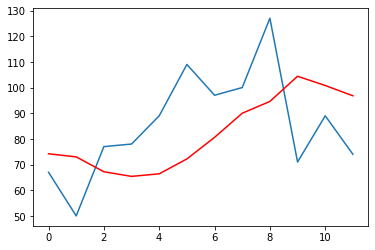

Neighborhood #: 20
Name: Nicollet Island - East Bank
Actuals: [7, 7, 7, 9, 6, 4, 11, 15, 10, 9, 6, 6]
Predictions: [8.4, 7.8, 6.0, 6.0, 6.8, 7.2, 6.6, 7.4, 9.0, 9.2, 9.8, 10.2]


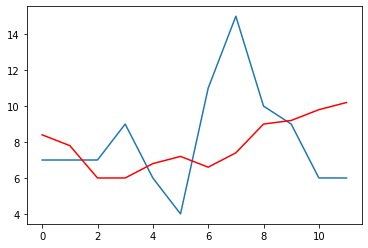

Neighborhood #: 21
Name: Columbia Park
Actuals: [1, 1, 2, 1, 4, 6, 4, 6, 5, 4, 3, 5]
Predictions: [7.6, 6.4, 5.2, 4.4, 3.0, 1.8, 2.8, 3.4, 4.2, 5.0, 5.0, 4.4]


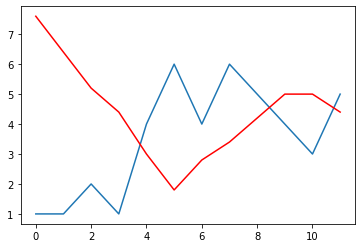

Neighborhood #: 22
Name: Wenonah
Actuals: [6, 10, 8, 6, 11, 9, 11, 10, 5, 9, 14, 12]
Predictions: [10.8, 9.2, 8.8, 8.8, 7.8, 8.2, 8.8, 9.0, 9.4, 9.2, 8.8, 9.8]


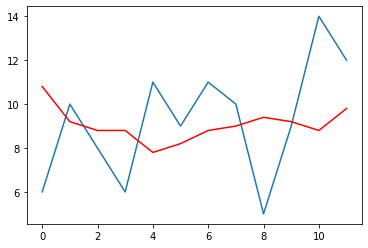

Neighborhood #: 23
Name: Marcy Holmes
Actuals: [47, 28, 27, 45, 57, 54, 75, 68, 76, 58, 54, 32]
Predictions: [67.8, 65.2, 55.6, 46.2, 43.0, 40.8, 42.2, 51.6, 59.8, 66.0, 66.2, 66.2]


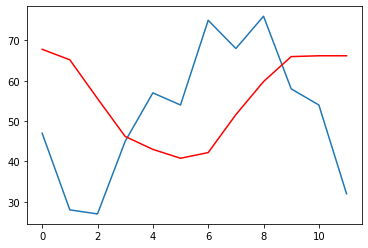

Neighborhood #: 24
Name: Longfellow
Actuals: [50, 44, 68, 65, 67, 54, 66, 79, 61, 57, 54, 63]
Predictions: [45.0, 45.8, 46.0, 49.8, 54.0, 58.8, 59.6, 64.0, 66.2, 65.4, 63.4, 63.4]


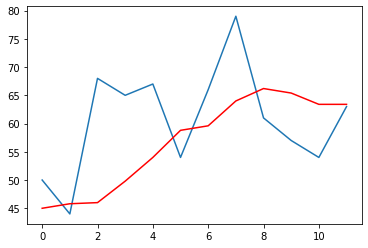

Neighborhood #: 25
Name: Central
Actuals: [11, 12, 19, 16, 24, 31, 27, 45, 33, 32, 34, 30]
Predictions: [33.4, 27.2, 20.4, 18.4, 16.8, 16.4, 20.4, 23.4, 28.6, 32.0, 33.6, 34.2]


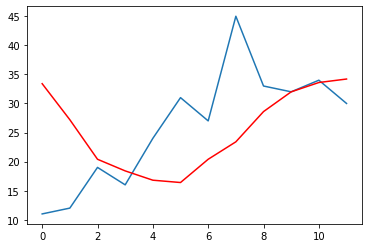

Neighborhood #: 26
Name: Phillips West
Actuals: [16, 18, 13, 20, 13, 26, 33, 42, 22, 13, 19, 17]
Predictions: [22.6, 18.8, 17.6, 15.6, 17.0, 16.0, 18.0, 21.0, 26.8, 27.2, 27.2, 25.8]


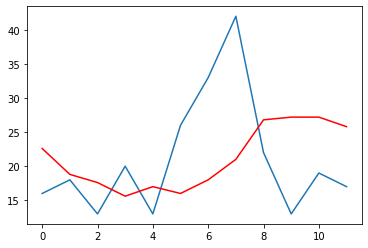

Neighborhood #: 27
Name: Jordan
Actuals: [49, 32, 35, 22, 30, 45, 44, 34, 34, 30, 34, 40]
Predictions: [59.6, 56.2, 52.2, 48.2, 37.4, 33.6, 32.8, 35.2, 35.0, 37.4, 37.4, 35.2]


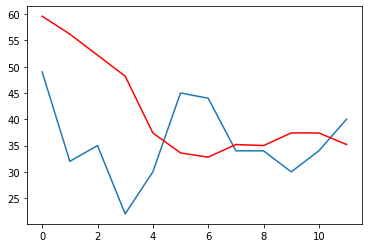

Neighborhood #: 28
Name: Folwell
Actuals: [31, 14, 18, 21, 26, 25, 23, 33, 24, 28, 26, 35]
Predictions: [27.6, 26.4, 24.4, 21.6, 21.4, 22.0, 20.8, 22.6, 25.6, 26.2, 26.6, 26.8]


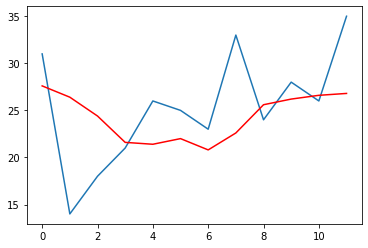

Neighborhood #: 29
Name: Bryant
Actuals: [8, 7, 1, 2, 4, 8, 11, 8, 17, 8, 13, 6]
Predictions: [10.0, 9.6, 7.6, 6.2, 5.6, 4.4, 4.4, 5.2, 6.6, 9.6, 10.4, 11.4]


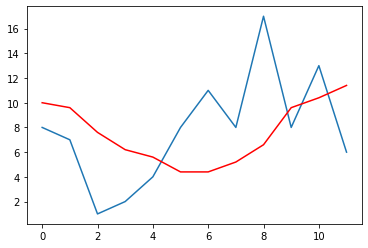

Neighborhood #: 30
Name: Cedar - Isles - Dean
Actuals: [2, 4, 4, 2, 10, 10, 5, 13, 6, 10, 7, 8]
Predictions: [6.4, 4.8, 4.2, 3.8, 3.4, 4.4, 6.0, 6.2, 8.0, 8.8, 8.8, 8.2]


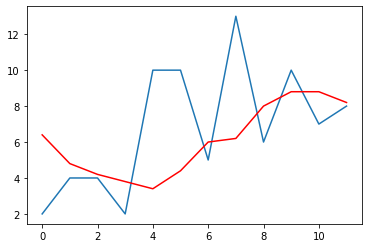

Neighborhood #: 31
Name: Webber - Camden
Actuals: [16, 13, 17, 22, 23, 34, 28, 30, 23, 21, 22, 32]
Predictions: [20.0, 17.6, 15.6, 16.4, 17.4, 18.2, 21.8, 24.8, 27.4, 27.6, 27.2, 24.8]


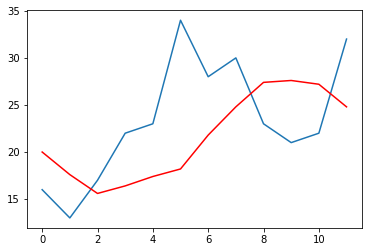

Neighborhood #: 32
Name: Mid - City Industrial
Actuals: [8, 2, 6, 4, 4, 6, 8, 8, 4, 5, 8, 10]
Predictions: [8.6, 8.2, 6.4, 6.4, 6.0, 4.8, 4.4, 5.6, 6.0, 6.0, 6.2, 6.6]


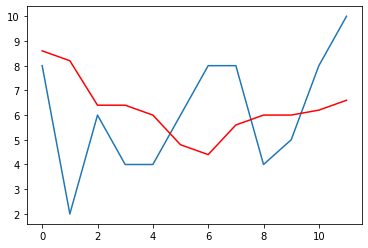

Neighborhood #: 33
Name: University Of Minnesota
Actuals: [6, 7, 9, 9, 11, 10, 10, 1, 6, 11, 6, 6]
Predictions: [10.0, 8.2, 7.6, 7.0, 7.4, 8.4, 9.2, 9.8, 8.2, 7.6, 7.6, 6.8]


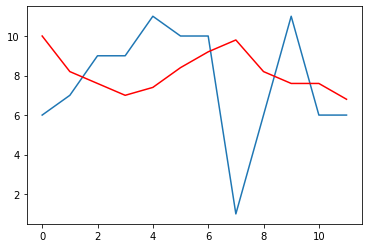

Neighborhood #: 34
Name: Camden Industrial
Actuals: [1, 1, 3, 1, 3, 2, 2, 1, 1]
Predictions: [2.8, 1.8, 1.4, 1.8, 1.6, 1.8, 2.0, 2.2, 1.8]


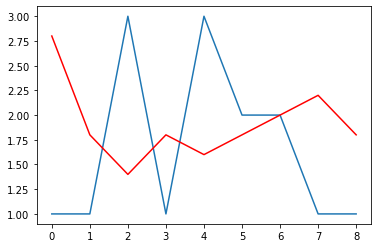

Neighborhood #: 35
Name: East Phillips
Actuals: [16, 21, 24, 36, 18, 35, 41, 34, 34, 32, 31, 23]
Predictions: [28.0, 25.2, 23.8, 21.6, 23.6, 23.0, 26.8, 30.8, 32.8, 32.4, 35.2, 34.4]


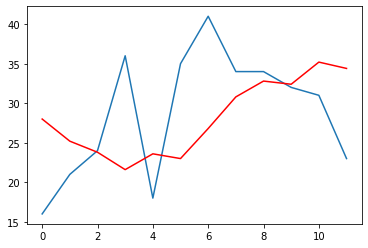

Neighborhood #: 36
Name: Carag
Actuals: [29, 22, 20, 19, 22, 34, 42, 31, 34, 28, 27, 22]
Predictions: [28.4, 28.2, 26.8, 25.0, 23.2, 22.4, 23.4, 27.4, 29.6, 32.6, 33.8, 32.4]


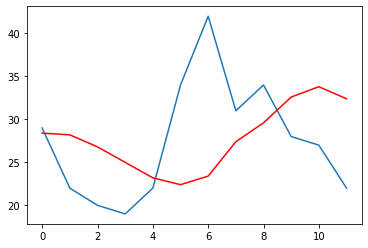

Neighborhood #: 37
Name: East Isles
Actuals: [20, 16, 13, 16, 23, 27, 37, 32, 27, 24, 15, 26]
Predictions: [23.6, 20.6, 17.0, 16.2, 16.4, 17.6, 19.0, 23.2, 27.0, 29.2, 29.4, 27.0]


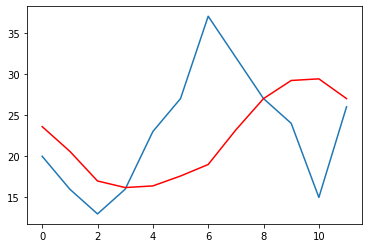

Neighborhood #: 38
Name: Ventura Village
Actuals: [36, 27, 17, 25, 38, 46, 30, 39, 38, 42, 39, 38]
Predictions: [30.2, 31.0, 30.2, 27.4, 25.8, 28.6, 30.6, 31.2, 35.6, 38.2, 39.0, 37.6]


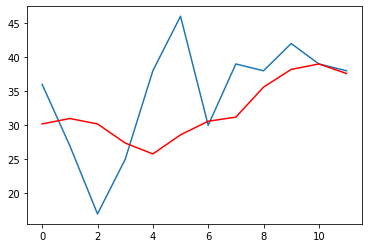

Neighborhood #: 39
Name: Hiawatha
Actuals: [12, 20, 17, 15, 28, 24, 39, 32, 26, 22, 36, 14]
Predictions: [20.6, 17.6, 15.6, 15.4, 15.2, 18.4, 20.8, 24.6, 27.6, 29.8, 28.6, 31.0]


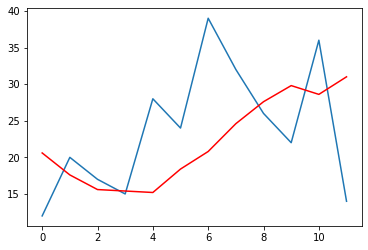

Neighborhood #: 40
Name: West Calhoun
Actuals: [10, 3, 5, 2, 7, 14, 10, 10, 7, 5, 5, 3]
Predictions: [10.2, 10.4, 8.4, 6.6, 5.0, 5.4, 6.2, 7.6, 8.6, 9.6, 9.2, 7.4]


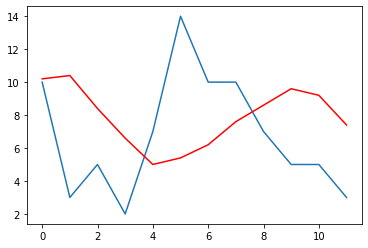

Neighborhood #: 41
Name: Powderhorn Park
Actuals: [32, 18, 26, 32, 43, 38, 38, 33, 37, 41, 41, 44]
Predictions: [36.2, 33.2, 28.6, 25.8, 25.0, 30.2, 31.4, 35.4, 36.8, 37.8, 37.4, 38.0]


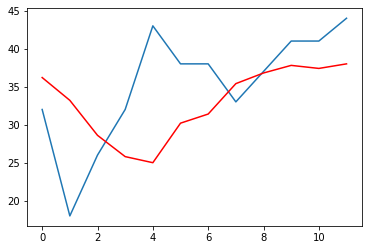

Neighborhood #: 42
Name: Near - North
Actuals: [32, 25, 35, 33, 37, 38, 36, 40, 37, 53, 42, 39]
Predictions: [51.4, 44.6, 36.8, 32.6, 31.6, 32.4, 33.6, 35.8, 36.8, 37.6, 40.8, 41.6]


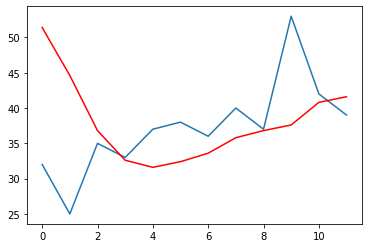

Neighborhood #: 43
Name: Midtown Phillips
Actuals: [24, 15, 18, 27, 26, 55, 44, 43, 52, 44, 36, 31]
Predictions: [29.4, 27.0, 25.4, 22.0, 21.4, 22.0, 28.2, 34.0, 39.0, 44.0, 47.6, 43.8]


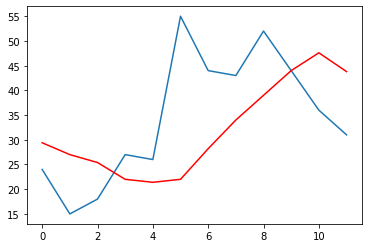

Neighborhood #: 44
Name: Downtown East
Actuals: [11, 24, 7, 30, 27, 16, 15, 36, 25, 20, 23, 22]
Predictions: [24.6, 22.0, 22.2, 18.8, 18.8, 19.8, 20.8, 19.0, 24.8, 23.8, 22.4, 23.8]


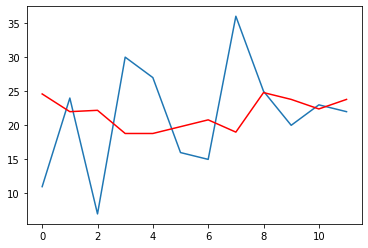

Neighborhood #: 45
Name: Elliot Park
Actuals: [28, 23, 33, 34, 47, 42, 45, 38, 44, 33, 39, 24]
Predictions: [32.4, 28.0, 26.6, 28.2, 28.8, 33.0, 35.8, 40.2, 41.2, 43.2, 40.4, 39.8]


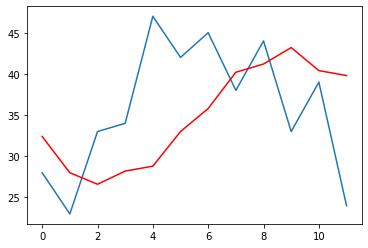

Neighborhood #: 46
Name: Harrison
Actuals: [5, 13, 18, 7, 6, 17, 18, 6, 12, 15, 15, 13]
Predictions: [16.8, 14.4, 13.2, 14.2, 11.8, 9.8, 12.2, 13.2, 10.8, 11.8, 13.6, 13.2]


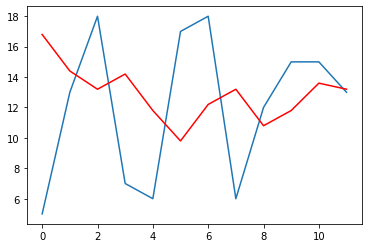

Neighborhood #: 47
Name: Hale
Actuals: [3, 3, 1, 5, 4, 9, 5, 4, 8, 5, 4, 7]
Predictions: [5.0, 5.0, 5.4, 4.6, 4.2, 3.2, 4.4, 4.8, 5.4, 6.0, 6.2, 5.2]


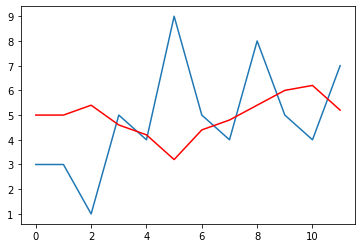

Neighborhood #: 48
Name: Keewaydin
Actuals: [3, 6, 4, 4, 6, 15, 6, 7, 3, 9, 5, 6]
Predictions: [8.8, 7.8, 7.4, 6.0, 4.2, 4.6, 7.0, 7.0, 7.6, 7.4, 8.0, 6.0]


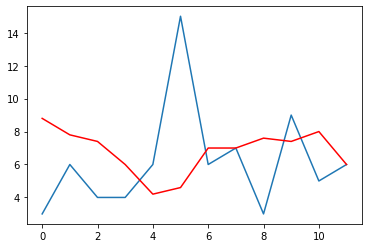

Neighborhood #: 49
Name: Waite Park
Actuals: [12, 12, 4, 10, 13, 11, 14, 9, 7, 6, 8, 12]
Predictions: [9.8, 10.2, 11.4, 9.8, 9.6, 10.2, 10.0, 10.4, 11.4, 10.8, 9.4, 8.8]


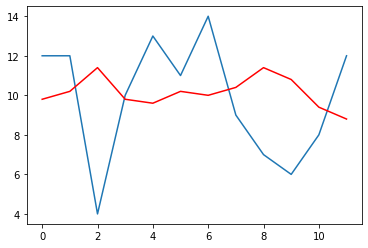

Neighborhood #: 50
Name: Logan Park
Actuals: [4, 3, 4, 8, 4, 4, 5, 7, 9, 8, 5, 8]
Predictions: [7.8, 6.4, 4.2, 4.0, 5.2, 4.6, 4.6, 5.0, 5.6, 5.8, 6.6, 6.8]


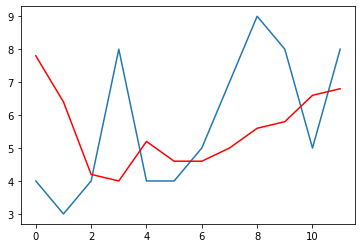

Neighborhood #: 51
Name: Lowry Hill East
Actuals: [45, 38, 47, 50, 67, 64, 72, 56, 76, 77, 57, 55]
Predictions: [45.0, 44.6, 44.8, 43.8, 43.4, 49.4, 53.2, 60.0, 61.8, 67.0, 69.0, 67.6]


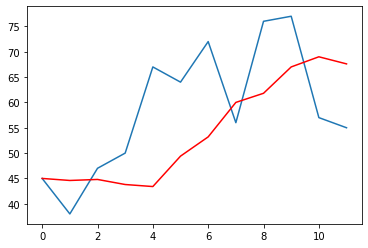

Neighborhood #: 52
Name: Bottineau
Actuals: [1, 7, 2, 7, 7, 6, 7, 5, 8, 10, 9, 9]
Predictions: [7.4, 6.2, 6.4, 5.4, 5.0, 4.8, 5.8, 5.8, 6.4, 6.6, 7.2, 7.8]


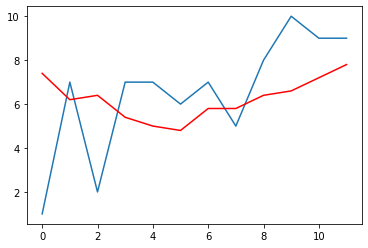

Neighborhood #: 53
Name: Lowry Hill
Actuals: [12, 12, 12, 11, 18, 18, 16, 15, 15, 10, 7, 17]
Predictions: [12.0, 10.8, 12.2, 10.6, 11.4, 13.0, 14.2, 15.0, 15.6, 16.4, 14.8, 12.6]


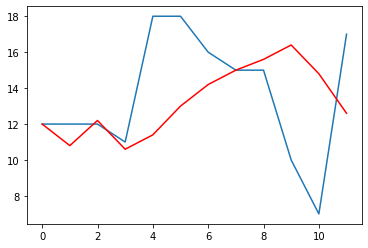

Neighborhood #: 54
Name: Seward
Actuals: [18, 24, 34, 40, 44, 52, 59, 55, 56, 44, 35, 28]
Predictions: [36.4, 32.2, 32.0, 31.4, 31.4, 32.0, 38.8, 45.8, 50.0, 53.2, 53.2, 49.8]


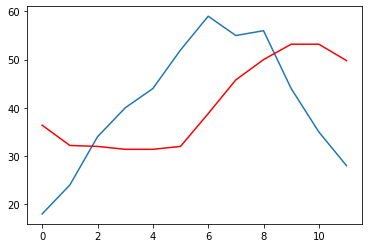

Neighborhood #: 55
Name: Diamond Lake
Actuals: [8, 4, 3, 6, 15, 26, 8, 6, 15, 15, 12, 4]
Predictions: [11.8, 10.6, 9.6, 8.4, 6.6, 7.2, 10.8, 11.6, 12.2, 14.0, 14.0, 11.2]


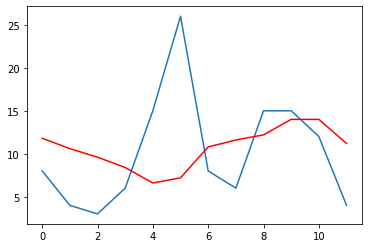

Neighborhood #: 56
Name: Cooper
Actuals: [10, 11, 6, 9, 5, 10, 8, 16, 13, 23, 7, 9]
Predictions: [12.6, 11.4, 11.6, 10.4, 8.8, 8.2, 8.2, 7.6, 9.6, 10.4, 14.0, 13.4]


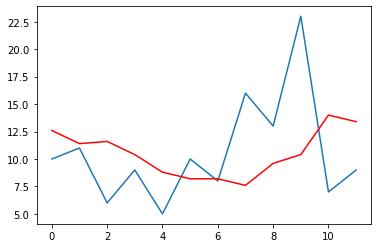

Neighborhood #: 57
Name: Tangletown
Actuals: [4, 7, 5, 7, 11, 15, 7, 15, 11, 10, 11, 13]
Predictions: [9.4, 6.8, 6.8, 6.2, 6.4, 6.8, 9.0, 9.0, 11.0, 11.8, 11.6, 10.8]


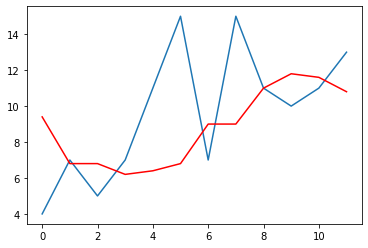

Neighborhood #: 58
Name: Northrop
Actuals: [13, 11, 9, 11, 10, 11, 12, 22, 19, 18, 10, 23]
Predictions: [17.0, 16.2, 15.0, 11.8, 11.4, 10.8, 10.4, 10.6, 13.2, 14.8, 16.4, 16.2]


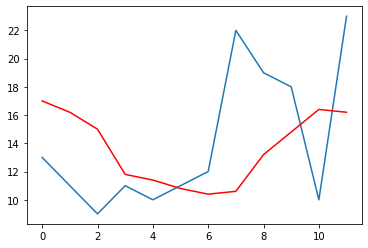

Neighborhood #: 59
Name: Prospect Park - East River Road
Actuals: [25, 23, 22, 24, 31, 34, 29, 34, 36, 55, 34, 22]
Predictions: [37.8, 35.8, 31.2, 25.0, 23.2, 25.0, 26.8, 28.0, 30.4, 32.8, 37.6, 37.6]


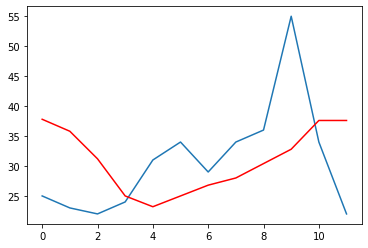

Neighborhood #: 60
Name: Audubon Park
Actuals: [7, 7, 8, 18, 8, 14, 17, 10, 12, 16, 7, 9]
Predictions: [20.4, 18.0, 18.2, 13.0, 11.8, 9.6, 11.0, 13.0, 13.4, 12.2, 13.8, 12.4]


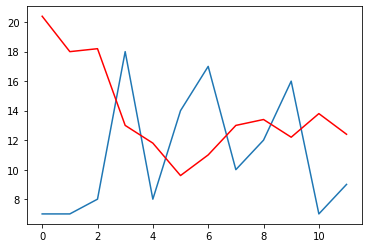

Neighborhood #: 61
Name: Cedar Riverside
Actuals: [23, 23, 21, 27, 40, 44, 35, 34, 29, 26, 31, 17]
Predictions: [33.8, 28.2, 25.2, 22.8, 23.2, 26.8, 31.0, 33.4, 36.0, 36.4, 33.6, 31.0]


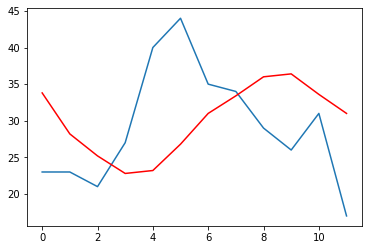

Neighborhood #: 62
Name: Field
Actuals: [2, 2, 3, 6, 5, 11, 4, 8, 8, 10, 7, 2]
Predictions: [8.6, 7.6, 5.2, 4.2, 4.0, 3.6, 5.4, 5.8, 6.8, 7.2, 8.2, 7.4]


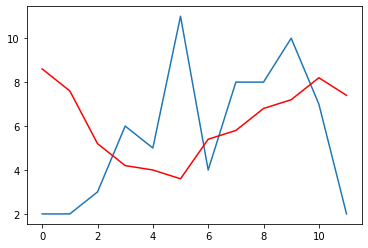

Neighborhood #: 63
Name: Minnehaha
Actuals: [12, 5, 7, 8, 4, 7, 10, 13, 10, 15, 12, 9]
Predictions: [9.2, 9.2, 7.4, 7.0, 7.0, 7.2, 6.2, 7.2, 8.4, 8.8, 11.0, 12.0]


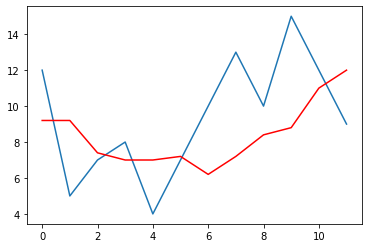

Neighborhood #: 64
Name: Sumner - Glenwood
Actuals: [5, 5, 2, 4, 2, 15, 10, 10, 4, 6, 7, 3]
Predictions: [7.2, 6.2, 6.0, 5.4, 4.6, 3.6, 5.6, 6.6, 8.2, 8.2, 9.0, 7.4]


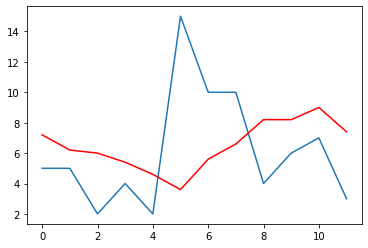

Neighborhood #: 65
Name: Howe
Actuals: [14, 19, 20, 13, 16, 21, 24, 27, 16, 24, 8, 8]
Predictions: [23.6, 22.6, 21.0, 18.6, 17.0, 16.4, 17.8, 18.8, 20.2, 20.8, 22.4, 19.8]


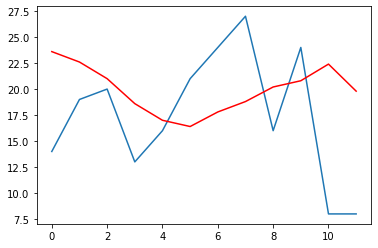

Neighborhood #: 66
Name: Marshall Terrace
Actuals: [5, 3, 3, 4, 10, 3, 2, 3, 7, 7, 4, 3]
Predictions: [7.0, 5.8, 5.0, 5.2, 4.2, 5.0, 4.6, 4.4, 4.4, 5.0, 4.4, 4.6]


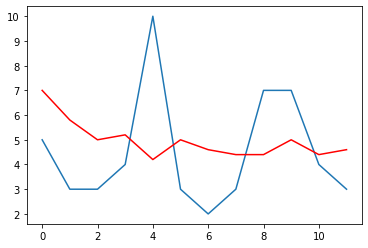

Neighborhood #: 67
Name: Stevens Square - Loring Heights
Actuals: [14, 12, 12, 18, 19, 19, 12, 18, 22, 22, 22, 15]
Predictions: [18.8, 17.8, 17.0, 14.8, 14.2, 15.0, 16.0, 16.0, 17.2, 18.0, 18.6, 19.2]


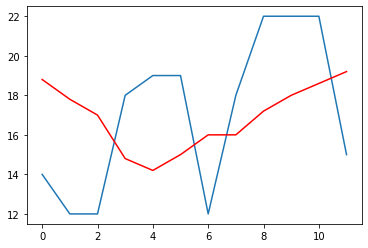

Neighborhood #: 68
Name: Fulton
Actuals: [7, 6, 6, 7, 10, 16, 15, 5, 12, 5, 8, 9]
Predictions: [15.2, 15.0, 14.4, 11.8, 10.2, 7.2, 9.0, 10.8, 10.6, 11.6, 10.6, 9.0]


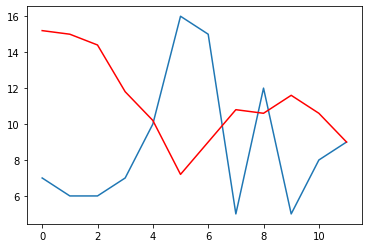

Neighborhood #: 69
Name: King Field
Actuals: [12, 13, 20, 18, 15, 21, 18, 19, 13, 18, 23, 22]
Predictions: [22.6, 22.0, 19.2, 17.2, 16.2, 15.6, 17.4, 18.4, 18.2, 17.2, 17.8, 18.2]


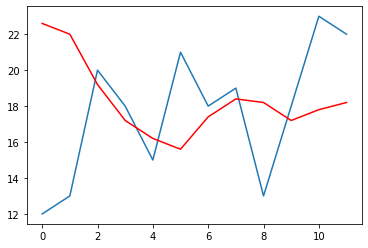

Neighborhood #: 70
Name: Bryn - Mawr
Actuals: [6, 4, 7, 4, 6, 10, 3, 9, 11, 6, 9, 4]
Predictions: [9.4, 8.6, 7.0, 6.2, 5.2, 5.4, 6.2, 6.0, 6.4, 7.8, 7.8, 7.6]


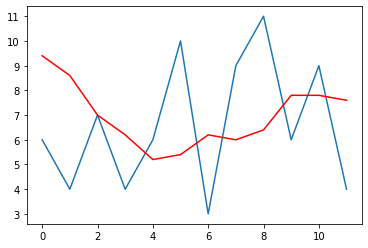

Neighborhood #: 71
Name: Cleveland
Actuals: [13, 9, 8, 6, 7, 10, 16, 6, 8, 9, 9, 13]
Predictions: [12.4, 11.4, 10.8, 10.0, 9.2, 8.6, 8.0, 9.4, 9.0, 9.4, 9.8, 9.6]


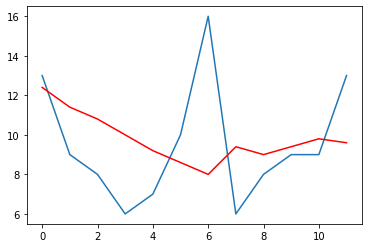

Neighborhood #: 72
Name: Regina
Actuals: [2, 7, 6, 4, 2, 5, 6, 9, 8, 6, 12, 5]
Predictions: [6.2, 5.8, 5.8, 4.8, 4.6, 4.2, 4.8, 4.6, 5.2, 6.0, 6.8, 8.2]


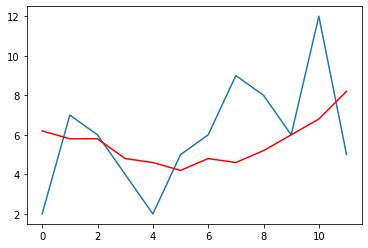

Neighborhood #: 73
Name: Linden Hills
Actuals: [8, 9, 8, 13, 8, 11, 11, 7, 14, 14, 10, 7]
Predictions: [15.6, 15.2, 13.4, 10.2, 10.0, 9.2, 9.8, 10.2, 10.0, 10.2, 11.4, 11.2]


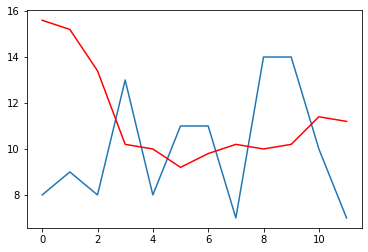

Neighborhood #: 74
Name: Armatage
Actuals: [3, 5, 2, 11, 11, 10, 6, 5, 2, 5, 6, 5]
Predictions: [9.8, 8.4, 7.0, 6.0, 6.8, 6.4, 7.8, 8.0, 8.6, 6.8, 5.6, 4.8]


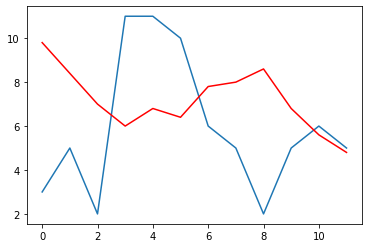

Neighborhood #: 75
Name: Northeast Park
Actuals: [12, 13, 8, 13, 16, 14, 16, 14, 14, 14, 12, 17]
Predictions: [14.0, 14.6, 13.6, 12.0, 12.6, 12.4, 12.8, 13.4, 14.6, 14.8, 14.4, 14.0]


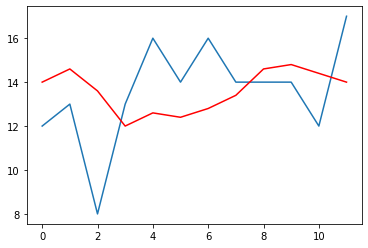

Neighborhood #: 76
Name: St. Anthony West
Actuals: [6, 2, 2, 5, 12, 11, 7, 2, 6, 6, 5, 7]
Predictions: [5.0, 5.4, 5.0, 4.0, 3.8, 5.4, 6.4, 7.4, 7.4, 7.6, 6.4, 5.2]


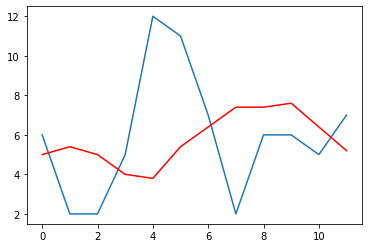

Neighborhood #: 77
Name: Kenny
Actuals: [2, 6, 4, 5, 6, 5, 2, 12, 6, 1, 10, 2]
Predictions: [9.0, 7.2, 7.2, 6.8, 5.8, 4.6, 5.2, 4.4, 6.0, 6.2, 5.2, 6.2]


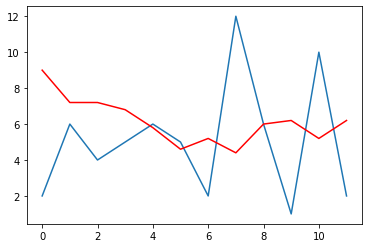

Neighborhood #: 78
Name: Bancroft
Actuals: [2, 6, 12, 7, 15, 11, 8, 13, 21, 12, 14, 16]
Predictions: [12.0, 10.0, 7.6, 7.8, 7.2, 8.4, 10.2, 10.6, 10.8, 13.6, 13.0, 13.6]


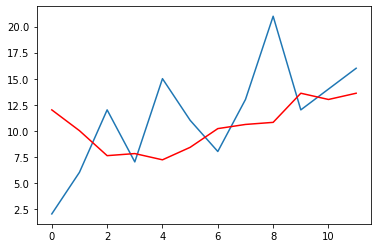

Neighborhood #: 79
Name: Windom Park
Actuals: [12, 11, 10, 7, 7, 22, 17, 15, 12, 12, 14, 12]
Predictions: [13.6, 13.6, 14.2, 11.8, 10.6, 9.4, 11.4, 12.6, 13.6, 14.6, 15.6, 14.0]


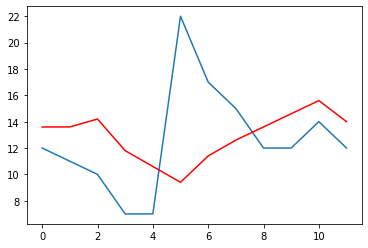

Neighborhood #: 80
Name: Ericsson
Actuals: [5, 6, 6, 12, 10, 15, 6, 14, 11, 15, 10, 19]
Predictions: [11.6, 11.2, 9.4, 6.4, 8.0, 7.8, 9.8, 9.8, 11.4, 11.2, 12.2, 11.2]


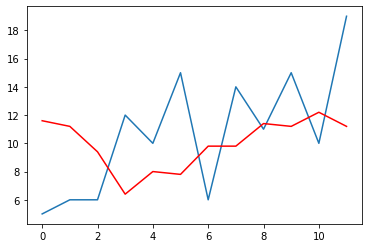

Neighborhood #: 81
Name: Lynnhurst
Actuals: [6, 7, 6, 7, 6, 6, 3, 10, 7, 7, 13, 4]
Predictions: [12.0, 11.4, 10.0, 10.0, 9.2, 6.4, 6.4, 5.6, 6.4, 6.4, 6.6, 8.0]


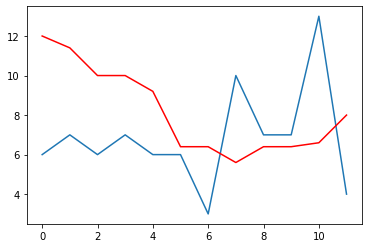

Neighborhood #: 82
Name: Morris Park
Actuals: [3, 2, 4, 6, 10, 2, 3, 2, 9, 8]
Predictions: [4.8, 4.8, 4.6, 4.4, 4.4, 5.0, 4.8, 5.0, 4.6, 5.2]


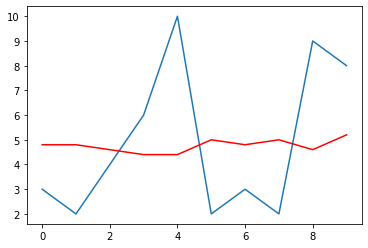

Neighborhood #: 83
Name: Page
Actuals: [1, 2, 2, 1, 3, 5, 7, 2, 2, 2]
Predictions: [3.6, 3.2, 2.8, 2.4, 1.4, 1.8, 2.6, 3.6, 3.6, 3.8]


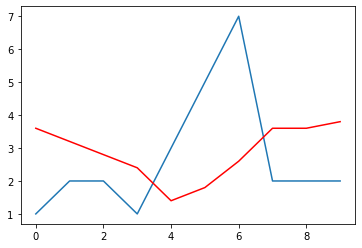

Neighborhood #: 84
Name: Sheridan
Actuals: [5, 4, 8, 7, 9, 5, 7, 12, 8, 15, 21, 10]
Predictions: [10.4, 7.2, 5.6, 7.0, 6.6, 6.6, 6.6, 7.2, 8.0, 8.2, 9.4, 12.6]


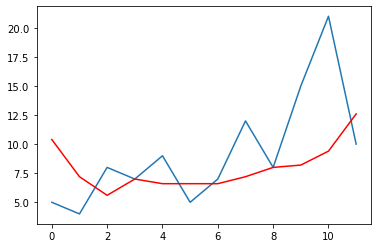

Neighborhood #: 85
Name: Beltrami
Actuals: [3, 4, 8, 8, 6, 3, 8, 4, 1, 7, 3, 3]
Predictions: [3.6, 3.8, 3.8, 4.2, 5.4, 5.8, 5.8, 6.6, 5.8, 4.4, 4.6, 4.6]


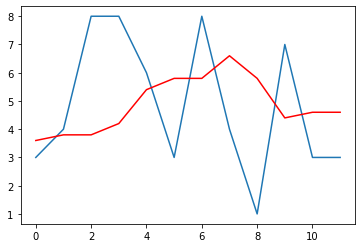

Neighborhood #: 86
Name: Kenwood
Actuals: [2, 1, 1, 1, 3, 6, 1, 6, 1, 3, 4, 1]
Predictions: [3.6, 2.6, 2.4, 1.6, 1.4, 1.6, 2.4, 2.4, 3.4, 3.4, 3.4, 3.0]


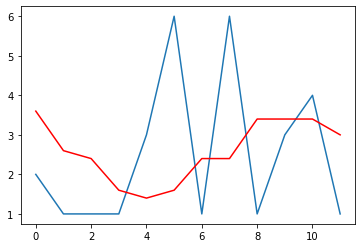

Neighborhood #: 87
Name: Humboldt Industrial Area
Actuals: [1, 1, 1, 1, 1, 1, 1]
Predictions: [1.8, 1.8, 1.8, 1.4, 1.2, 1.0, 1.0]


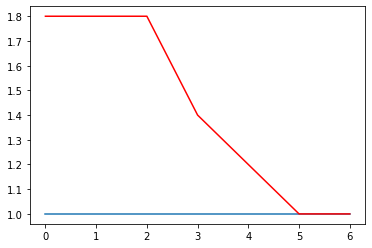

Test RMSE: 8.538


In [13]:
# prepare situation
window = 5
predTot = list()
testTot = list()
# walk forward over time steps in test
for neighborhoodNum in range(len(train_n)):
    
    history = train_n[neighborhoodNum]
    test = test_n[neighborhoodNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Neighborhood #: {}'.format(neighborhoodNum+1))
    print('Name: {}'.format(neighborhood_list[neighborhoodNum]))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

# Neighborhood weekly predictions

In [14]:
# Training data by neighborhood by month
train_n = []
for neighborhood in neighborhood_list:
    df = incidents_train[incidents_train['neighborhood'] == neighborhood]
    df_gr = df.groupby(['year', 'weekOfYear']).count()
    train_n.append(list(df_gr['incidentDate'].values))

In [15]:
test_n = []
for neighborhood in neighborhood_list:
    df = incidents_test[incidents_test['neighborhood'] == neighborhood]
    df_gr = df.groupby(['weekOfYear']).count()
    test_n.append(list(df_gr['incidentDate'].values))

Neighborhood #: 1
Name: Windom


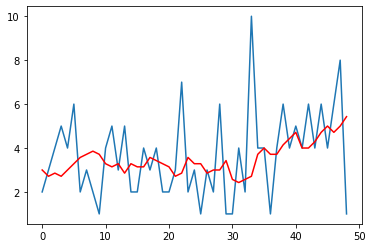

Neighborhood #: 2
Name: Corcoran


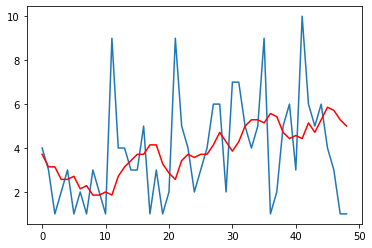

Neighborhood #: 3
Name: Holland


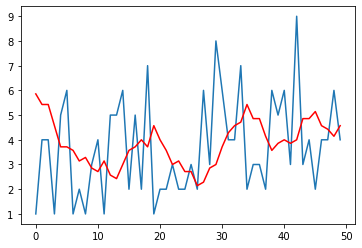

Neighborhood #: 4
Name: Downtown West


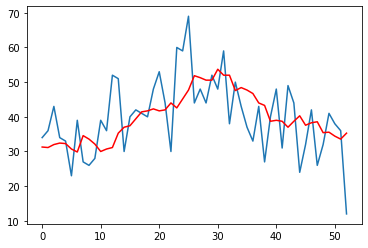

Neighborhood #: 5
Name: Standish


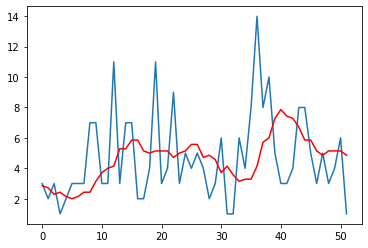

Neighborhood #: 6
Name: North Loop


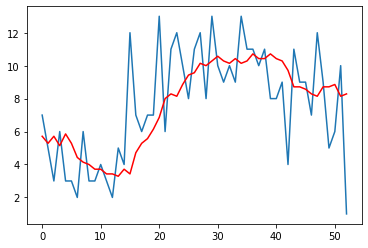

Neighborhood #: 7
Name: Hawthorne


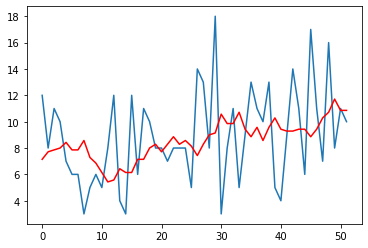

Neighborhood #: 8
Name: Loring Park


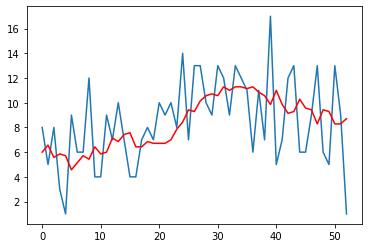

Neighborhood #: 9
Name: East Harriet


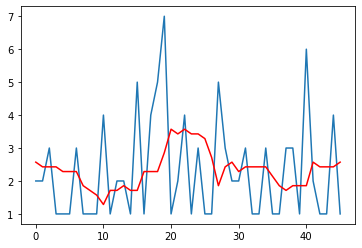

Neighborhood #: 10
Name: Lind - Bohanon


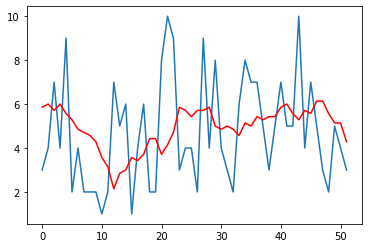

Neighborhood #: 11
Name: Como


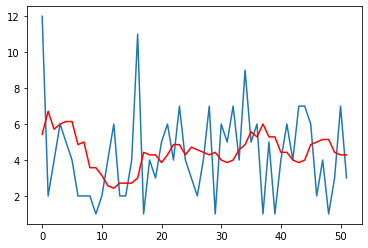

Neighborhood #: 12
Name: Victory


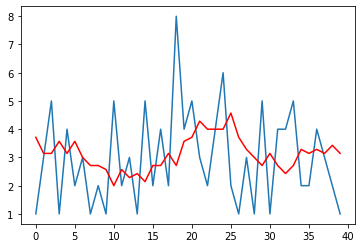

Neighborhood #: 13
Name: Lyndale


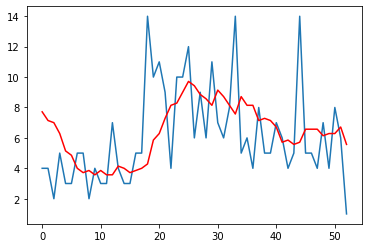

Neighborhood #: 14
Name: Shingle Creek


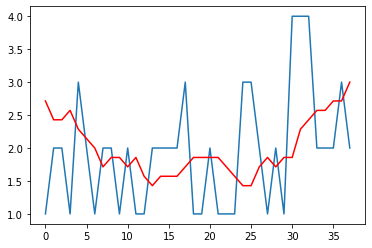

Neighborhood #: 15
Name: Mckinley


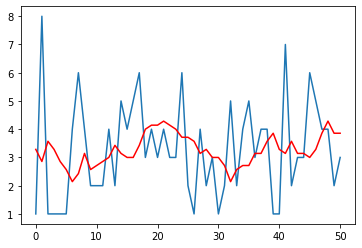

Neighborhood #: 16
Name: St. Anthony East


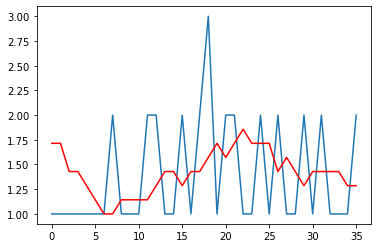

Neighborhood #: 17
Name: Willard - Hay


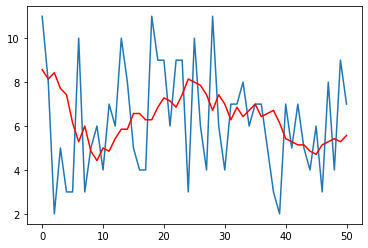

Neighborhood #: 18
Name: Ecco


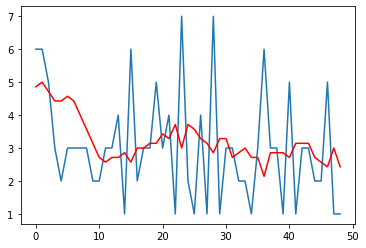

Neighborhood #: 19
Name: Whittier


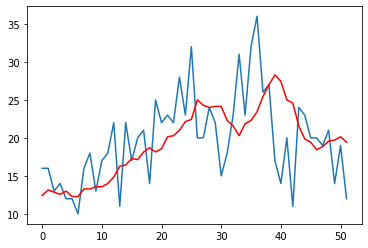

Neighborhood #: 20
Name: Nicollet Island - East Bank


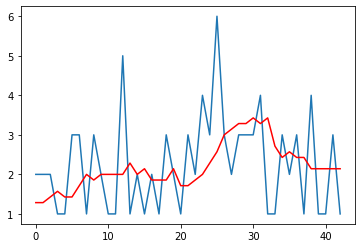

Neighborhood #: 21
Name: Columbia Park


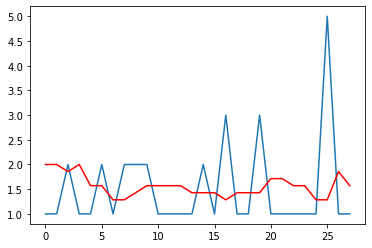

Neighborhood #: 22
Name: Wenonah


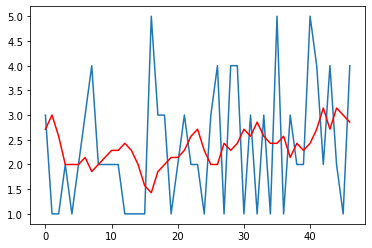

Neighborhood #: 23
Name: Marcy Holmes


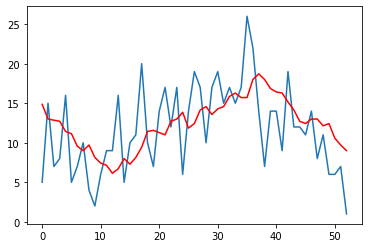

Neighborhood #: 24
Name: Longfellow


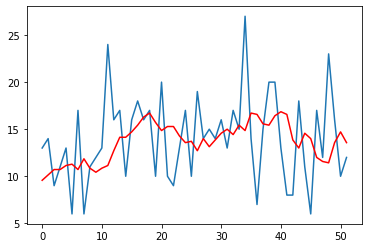

Neighborhood #: 25
Name: Central


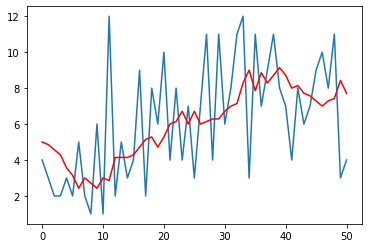

Neighborhood #: 26
Name: Phillips West


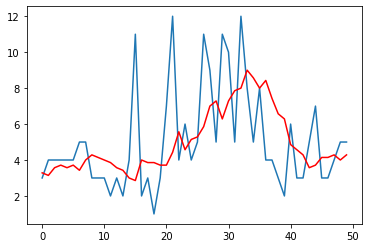

Neighborhood #: 27
Name: Jordan


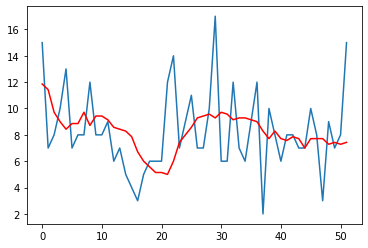

Neighborhood #: 28
Name: Folwell


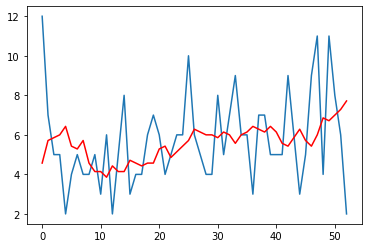

Neighborhood #: 29
Name: Bryant


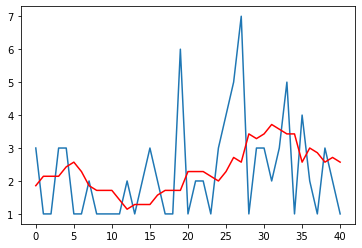

Neighborhood #: 30
Name: Cedar - Isles - Dean


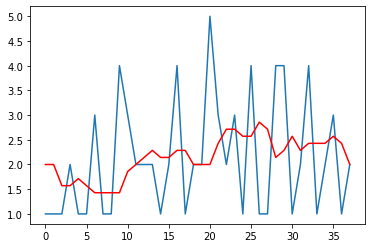

Neighborhood #: 31
Name: Webber - Camden


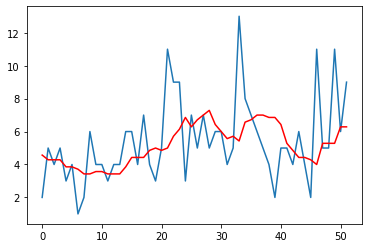

Neighborhood #: 32
Name: Mid - City Industrial


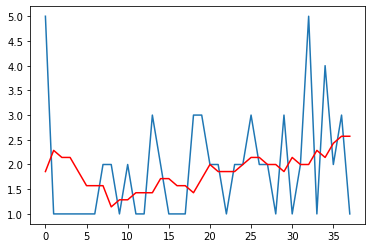

Neighborhood #: 33
Name: University Of Minnesota


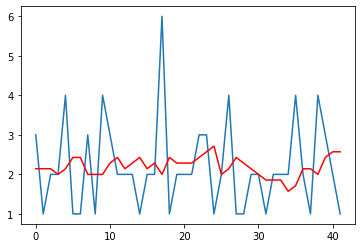

Neighborhood #: 34
Name: Camden Industrial


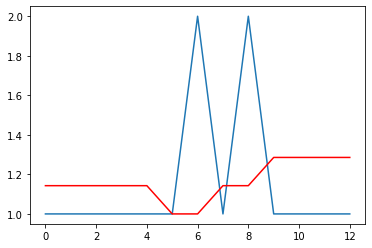

Neighborhood #: 35
Name: East Phillips


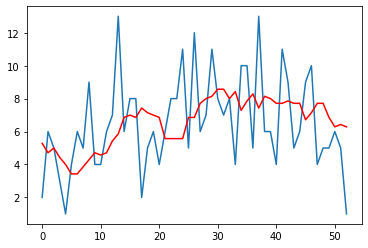

Neighborhood #: 36
Name: Carag


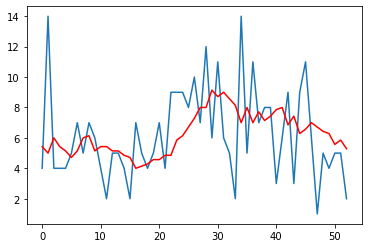

Neighborhood #: 37
Name: East Isles


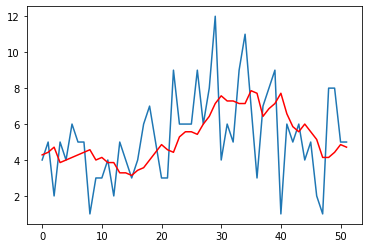

Neighborhood #: 38
Name: Ventura Village


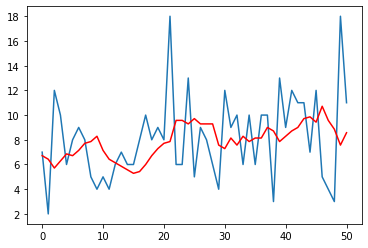

Neighborhood #: 39
Name: Hiawatha


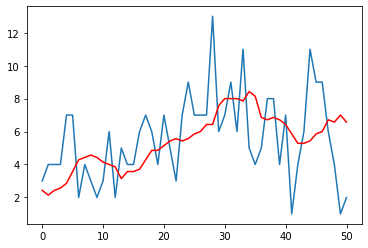

Neighborhood #: 40
Name: West Calhoun


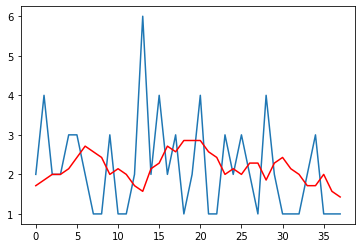

Neighborhood #: 41
Name: Powderhorn Park


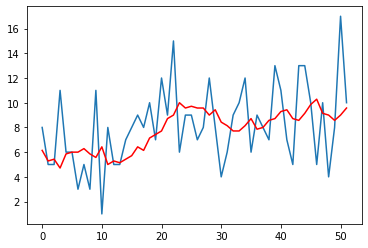

Neighborhood #: 42
Name: Near - North


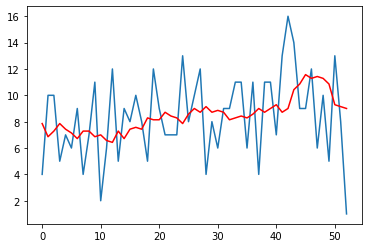

Neighborhood #: 43
Name: Midtown Phillips


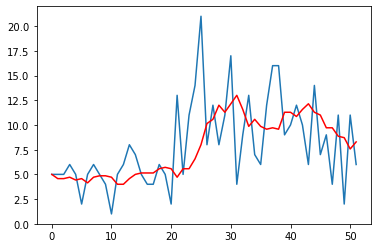

Neighborhood #: 44
Name: Downtown East


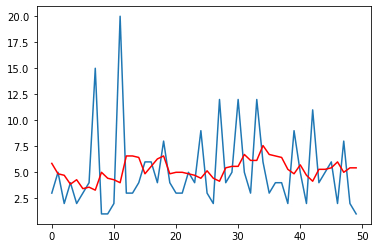

Neighborhood #: 45
Name: Elliot Park


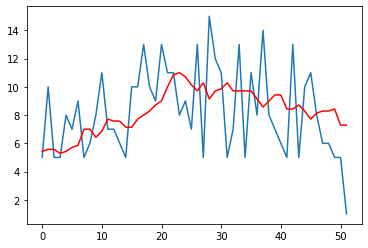

Neighborhood #: 46
Name: Harrison


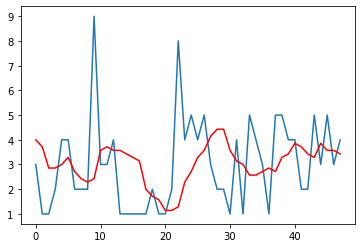

Neighborhood #: 47
Name: Hale


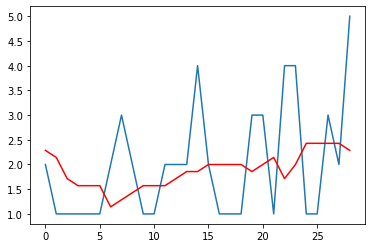

Neighborhood #: 48
Name: Keewaydin


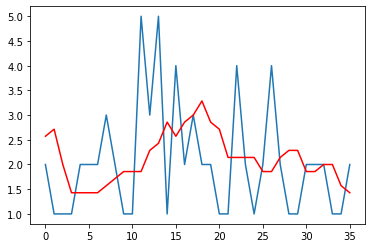

Neighborhood #: 49
Name: Waite Park


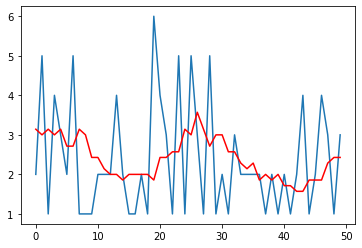

Neighborhood #: 50
Name: Logan Park


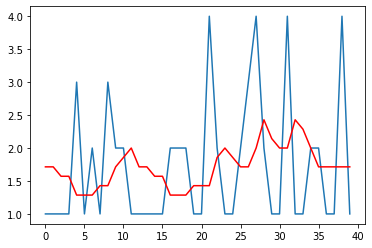

Neighborhood #: 51
Name: Lowry Hill East


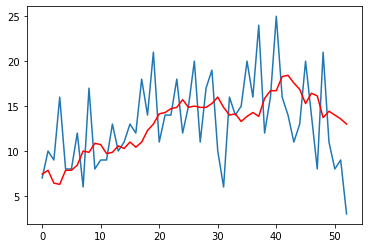

Neighborhood #: 52
Name: Bottineau


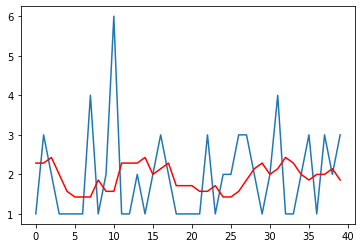

Neighborhood #: 53
Name: Lowry Hill


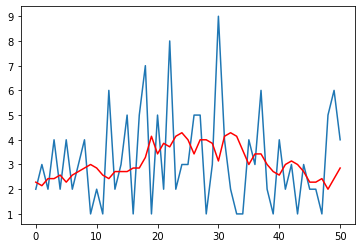

Neighborhood #: 54
Name: Seward


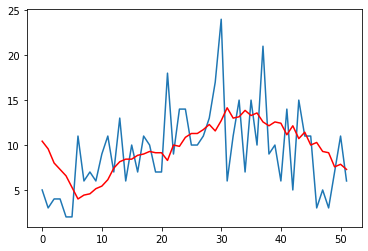

Neighborhood #: 55
Name: Diamond Lake


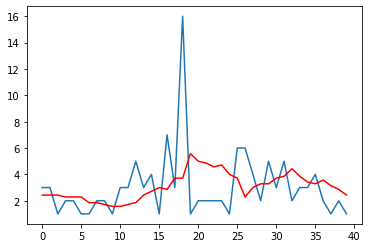

Neighborhood #: 56
Name: Cooper


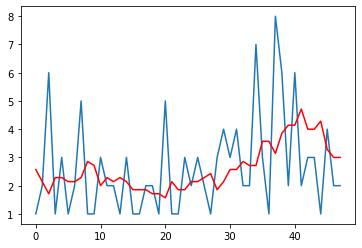

Neighborhood #: 57
Name: Tangletown


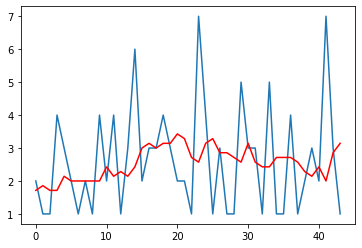

Neighborhood #: 58
Name: Northrop


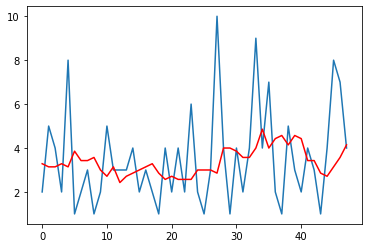

Neighborhood #: 59
Name: Prospect Park - East River Road


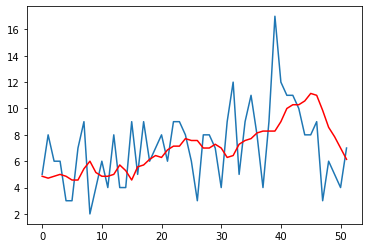

Neighborhood #: 60
Name: Audubon Park


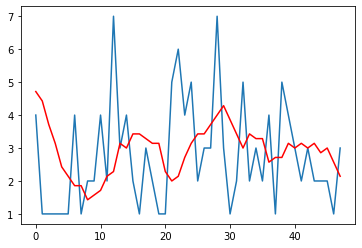

Neighborhood #: 61
Name: Cedar Riverside


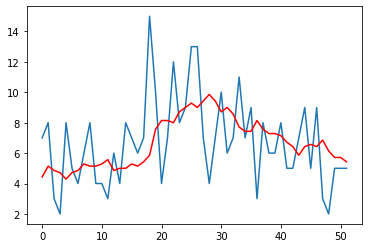

Neighborhood #: 62
Name: Field


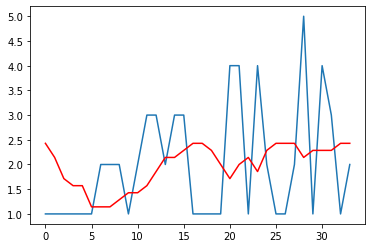

Neighborhood #: 63
Name: Minnehaha


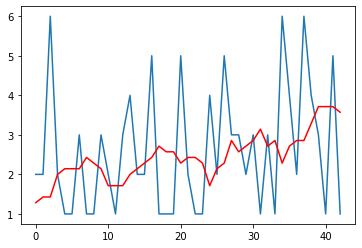

Neighborhood #: 64
Name: Sumner - Glenwood


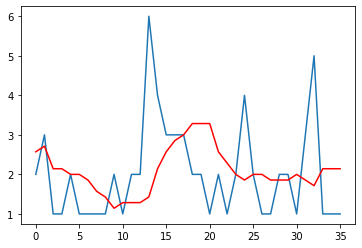

Neighborhood #: 65
Name: Howe


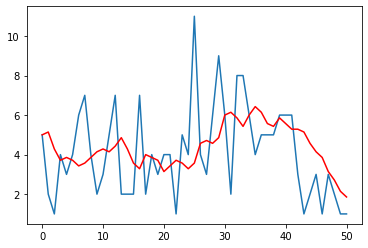

Neighborhood #: 66
Name: Marshall Terrace


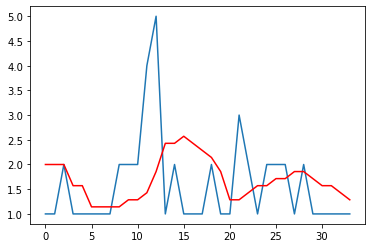

Neighborhood #: 67
Name: Stevens Square - Loring Heights


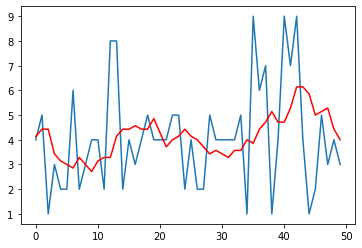

Neighborhood #: 68
Name: Fulton


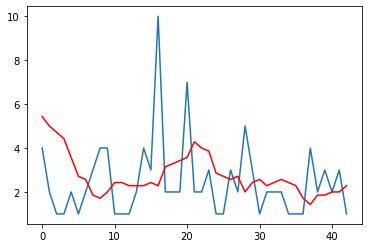

Neighborhood #: 69
Name: King Field


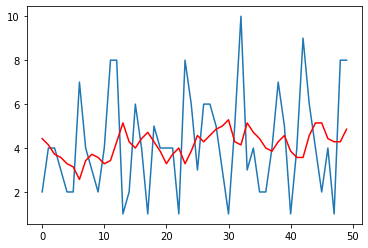

Neighborhood #: 70
Name: Bryn - Mawr


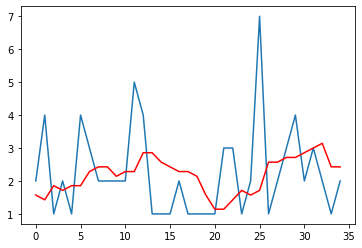

Neighborhood #: 71
Name: Cleveland


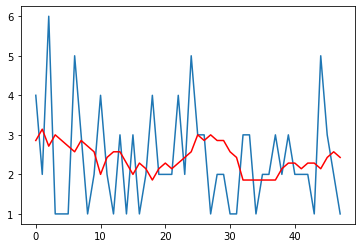

Neighborhood #: 72
Name: Regina


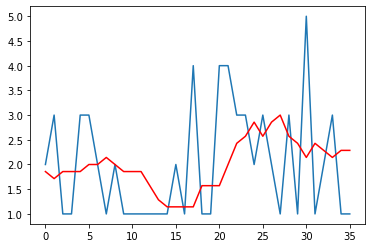

Neighborhood #: 73
Name: Linden Hills


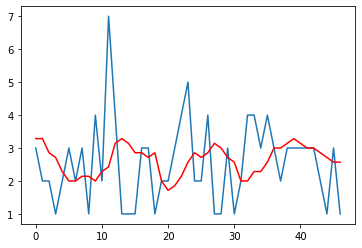

Neighborhood #: 74
Name: Armatage


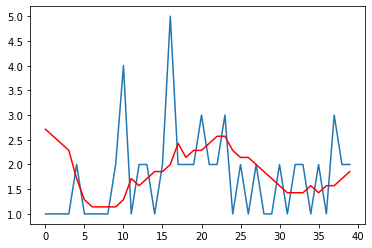

Neighborhood #: 75
Name: Northeast Park


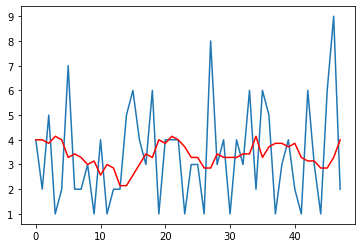

Neighborhood #: 76
Name: St. Anthony West


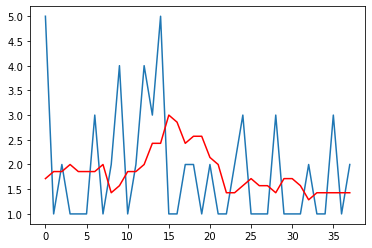

Neighborhood #: 77
Name: Kenny


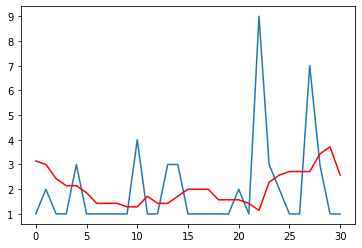

Neighborhood #: 78
Name: Bancroft


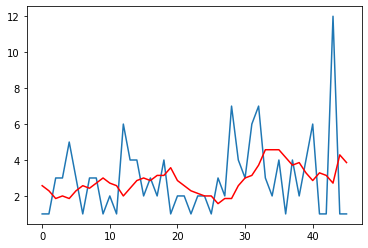

Neighborhood #: 79
Name: Windom Park


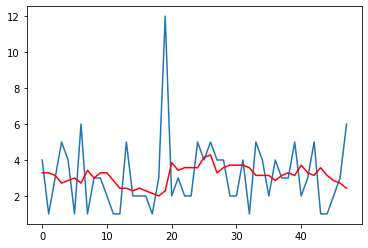

Neighborhood #: 80
Name: Ericsson


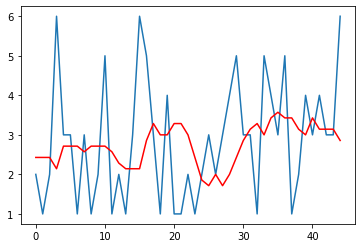

Neighborhood #: 81
Name: Lynnhurst


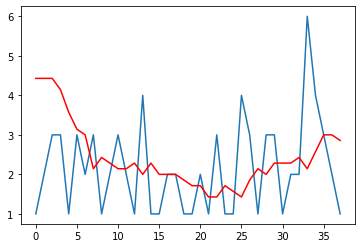

Neighborhood #: 82
Name: Morris Park


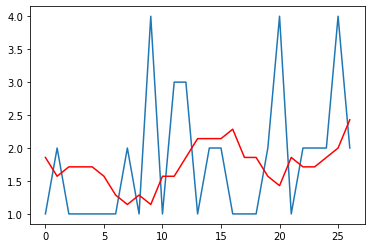

Neighborhood #: 83
Name: Page


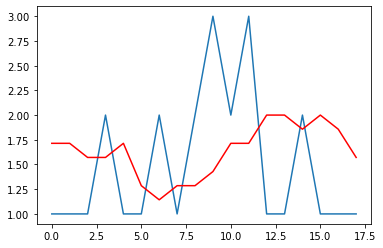

Neighborhood #: 84
Name: Sheridan


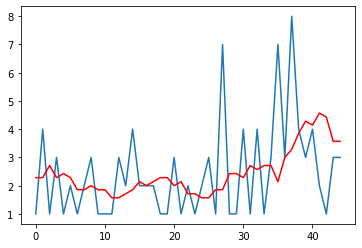

Neighborhood #: 85
Name: Beltrami


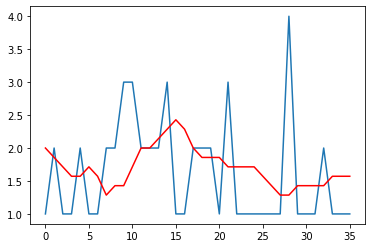

Neighborhood #: 86
Name: Kenwood


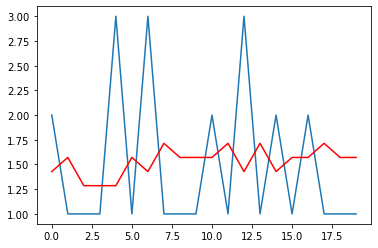

Neighborhood #: 87
Name: Humboldt Industrial Area


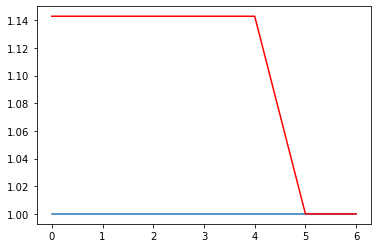

Test RMSE: 2.769


In [16]:
# prepare situation
window = 7
predTot = list()
testTot = list()
# walk forward over time steps in test
for neighborhoodNum in range(len(train_n)):
    
    history = train_n[neighborhoodNum]
    test = test_n[neighborhoodNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Neighborhood #: {}'.format(neighborhoodNum+1))
    print('Name: {}'.format(neighborhood_list[neighborhoodNum]))
    # print('Actuals: {}'.format(test))
    # print('Predictions: {}'.format(preds))
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

# Precinct Monthly Predictions

In [17]:
# Predictions by precinct
precinct_list = list(incidents['precinct'].unique())

In [18]:
train_p = []
for precinct in precinct_list:
    df = incidents_train[incidents_train['precinct'] == precinct]
    df_gr = df.groupby(['year', 'month']).count()
    train_p.append(list(df_gr['incidentDate'].values))

In [19]:
test_p = []
for precinct in precinct_list:
    df = incidents_test[incidents_test['precinct'] == precinct]
    df_gr = df.groupby(['month']).count()
    test_p.append(list(df_gr['incidentDate'].values))

Precinct: 1
Actuals: [303, 257, 292, 310, 410, 468, 416, 420, 451, 368, 392, 339]
Predictions: [411.75, 396.875, 367.5, 347.75, 335.25, 339.375, 346.625, 351.625, 359.5, 378.0, 391.875, 404.375]


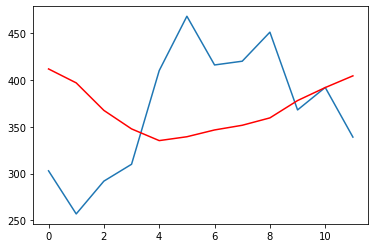

Precinct: 2
Actuals: [327, 314, 350, 420, 449, 569, 533, 608, 579, 535, 511, 463]
Predictions: [501.375, 472.375, 441.375, 413.125, 399.5, 394.125, 402.625, 415.125, 446.25, 477.75, 505.375, 525.5]


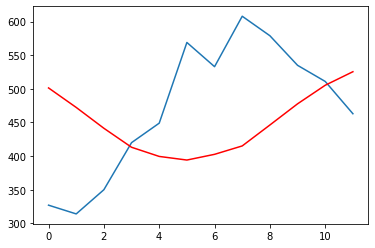

Precinct: 3
Actuals: [201, 157, 155, 219, 240, 241, 273, 272, 259, 281, 248, 210]
Predictions: [264.5, 262.375, 250.25, 240.625, 232.625, 226.25, 218.125, 219.25, 219.75, 227.0, 242.5, 254.125]


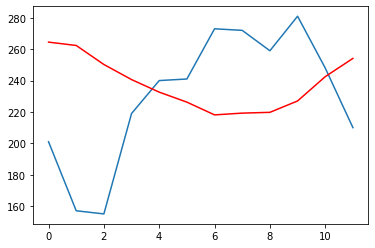

Precinct: 4
Actuals: [263, 232, 277, 316, 390, 416, 396, 424, 336, 339, 319, 303]
Predictions: [364.875, 354.0, 333.25, 309.5, 293.875, 296.0, 307.625, 320.875, 339.25, 348.375, 361.75, 367.0]


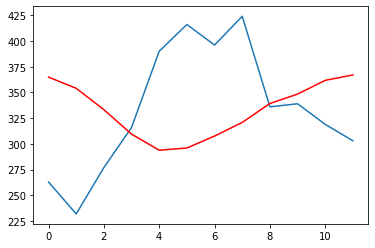

Precinct: 5
Actuals: [273, 198, 223, 233, 256, 328, 321, 275, 290, 291, 288, 305]
Predictions: [353.625, 342.375, 319.875, 302.875, 283.875, 269.875, 268.25, 267.125, 263.375, 265.5, 277.125, 285.25]


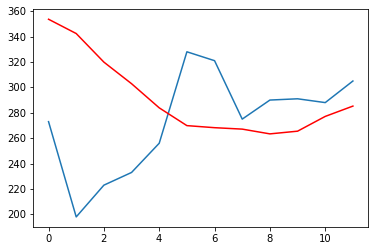

Precinct: 6
Actuals: []
Predictions: []


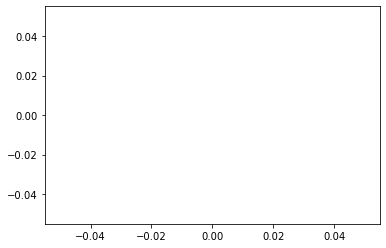

Precinct: 7
Actuals: []
Predictions: []


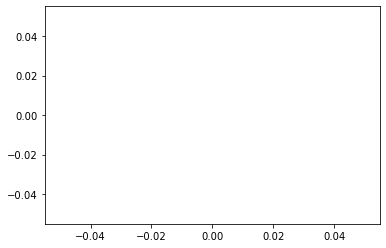

Test RMSE: 83.971


In [20]:
# prepare situation
window = 8
predTot = list()
testTot = list()
# walk forward over time steps in test
for precinctNum in range(len(train_p)):
    
    history = train_p[precinctNum]
    test = test_p[precinctNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Precinct: {}'.format(precinctNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

Weighted Moving Average

Precinct: 1
Actuals: [303, 257, 292, 310, 410, 468, 416, 420, 451, 368, 392, 339]
Predictions: [379.26666666666665, 348.93333333333334, 311.06666666666666, 297.8, 295.6, 332.2, 383.4, 406.26666666666665, 419.8666666666667, 435.26666666666665, 413.6, 402.73333333333335]


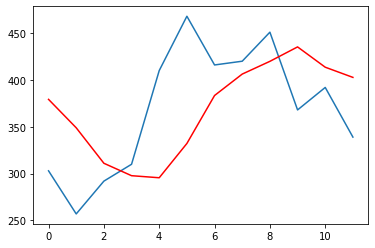

Precinct: 2
Actuals: [327, 314, 350, 420, 449, 569, 533, 608, 579, 535, 511, 463]
Predictions: [515.3333333333334, 444.6, 388.26666666666665, 361.6, 370.6, 395.3333333333333, 461.0, 498.53333333333336, 546.4666666666667, 567.5333333333333, 563.3333333333334, 545.4]


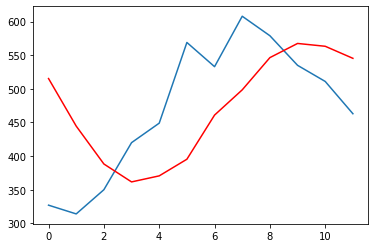

Precinct: 3
Actuals: [201, 157, 155, 219, 240, 241, 273, 272, 259, 281, 248, 210]
Predictions: [245.0, 227.33333333333334, 199.73333333333332, 178.26666666666668, 186.53333333333333, 203.73333333333332, 219.26666666666668, 242.8, 258.26666666666665, 261.6, 269.6, 263.8666666666667]


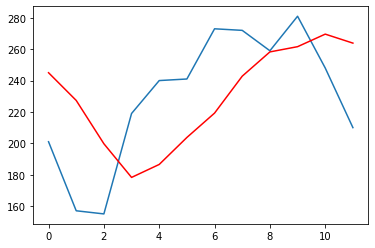

Precinct: 4
Actuals: [263, 232, 277, 316, 390, 416, 396, 424, 336, 339, 319, 303]
Predictions: [326.93333333333334, 299.8666666666667, 273.2, 268.46666666666664, 280.8666666666667, 318.1333333333333, 358.26666666666665, 381.53333333333336, 403.2, 385.73333333333335, 367.93333333333334, 346.8666666666667]


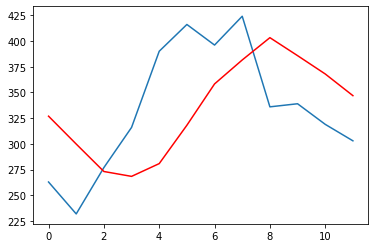

Precinct: 5
Actuals: [273, 198, 223, 233, 256, 328, 321, 275, 290, 291, 288, 305]
Predictions: [293.6666666666667, 288.06666666666666, 257.6, 241.6, 233.46666666666667, 236.66666666666666, 267.1333333333333, 291.6, 292.53333333333336, 295.0, 294.0, 289.6666666666667]


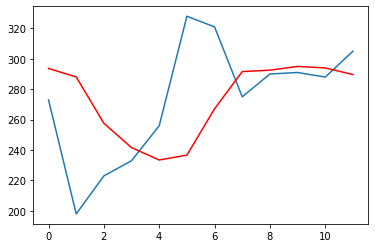

Precinct: 6
Actuals: []
Predictions: []


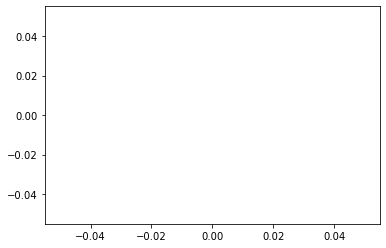

Precinct: 7
Actuals: []
Predictions: []


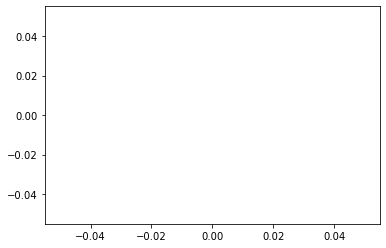

Test RMSE: 67.232


In [21]:
# prepare situation
window = 5
predTot = list()
testTot = list()
# walk forward over time steps in test
for precinctNum in range(len(train_p)):
    
    history = train_p[precinctNum]
    test = test_p[precinctNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = np.average([history[i] for i in range(length - window, length)], weights=[1,2,3,4,5])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('Precinct: {}'.format(precinctNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

Exponential Moving Average

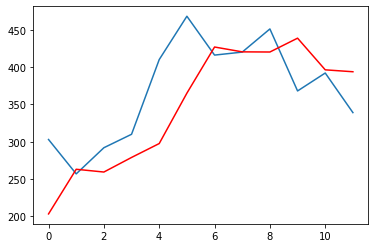

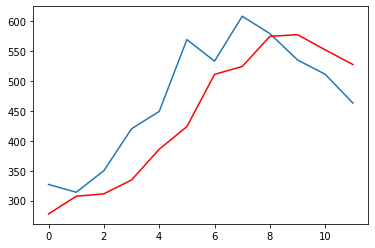

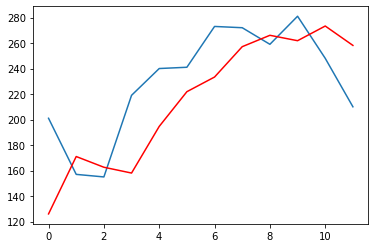

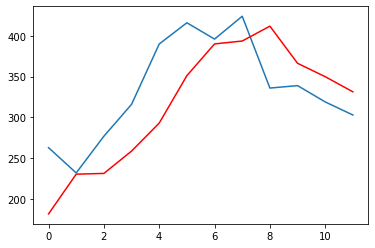

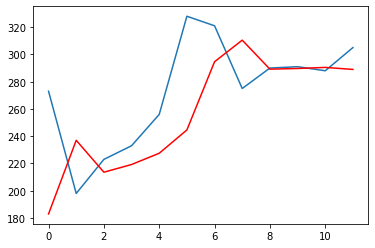

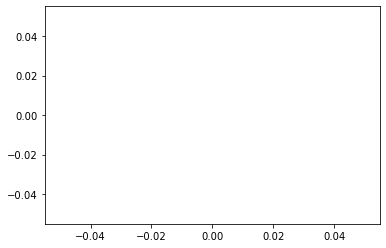

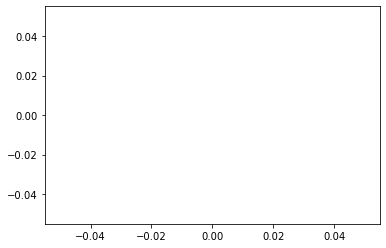

Test RMSE: 52.853


In [22]:
# prepare situation
predTot = list()
testTot = list()
alpha = 0.6
# walk forward over time steps in test
for precinctNum in range(len(train_p)):
    
    history = train_p[precinctNum]
    test = test_p[precinctNum]
    preds = []
    lastPred = 0
    for t in range(len(test)):
        yhat = ((1-alpha)*lastPred + (alpha*history[-1]))
        lastPred = yhat
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
        
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

In [ ]:
# Haven't used this yet...they used it in the NN part of their project (LSTM)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)